# Fast scattering
Scattering transform for downsampling 2D microscopy data.

Enforce invariance to rotation and reflection.

Small windows used to avoid FFTs.

Outputs are low resolution images, but with a high dimensional signal at each pixel.

3 dimensional PCA subspaces are used for visualization.


In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from scipy.stats import norm
import os


# Specify data to downsample

In [2]:
# load an image, here an example mouse Nissl slice from Allen Institute
fname = '/home/dtward/data/AllenInstitute/ARA/section_000227_11648.jpeg'
I0 = plt.imread(fname)


In [3]:
# convert to float
I0 = I0.astype(np.float32)/255.0

# Set parameters

In [4]:
# output folder
outdir = 'figures'

# how many nonlinearities are applied
max_scatter = 2 
# how many times to downsample with
n_scatter = 3
# how many initial downsampling steps before nonlinearities
n_init = 1
# how many final downsampling steps without nonlinearities
n_final = 2



In [5]:
#I = np.copy(I0) # we can copy if we want to keep the original, but this uses extra memory
I = I0

In [6]:
# initialize labels for each channel
labels = ['R','G','B']

# PCA code for visualizing

In [7]:
# now we need to take the pca and view it
def pca(I,w=None,output_v=False):
    if w is None:
        w = np.ones((I.shape[0],I.shape[1]))
    
    w = w.reshape(-1)[...,None]
    ws = np.sum(w)
    Iv = np.reshape(I,(I.shape[0]*I.shape[1],-1))
    Ivbar = np.sum(Iv*w,0,keepdims=True)/ws
    Iv0 = Iv - Ivbar
    S = (Iv0.T@(Iv0*w))/ws # divide by number of pixels
    w_,v = np.linalg.eigh(S)
    s = np.sqrt(w_)
    Ip = (Iv0@v).reshape(I.shape)
    
    
    if output_v:
        return Ip[...,::-1],s[::-1],v[:,::-1]
    # put in decreasing order and return
    return Ip[...,::-1],s[::-1]
def pca_scale(Ip,s):    
    return norm.cdf(Ip/s[None,None])

def draw(I,w=None):
    Ip,sI,vI = pca(I,w=w,output_v=True)
    Is = pca_scale(Ip[...,:7],sI[:7])
    # let's project L onto the first PC
    if w is not None:
        muI = np.sum(I*w[...,None],axis=(0,1),keepdims=True)/np.sum(w)
    else:
        muI = np.mean(I,axis=(0,1),keepdims=True)
    c = np.sum(vI[:,0]*(I - muI),-1)

    fav,ax = plt.subplots()
    ax.imshow(I[...,:3])
    ax.set_title('average')
    
    f1,ax = plt.subplots()
    ax.imshow(c[...,None]*vI[:3,0] + muI[...,:3])
    ax.set_title('PC 1 proj')

    fs1,ax = plt.subplots()
    ax.imshow(Is[...,1:4])
    ax.set_title('PC components 2 to 4')

    fs2,ax = plt.subplots()
    ax.imshow(Is[...,4:7])
    ax.set_title('PC components 5 to 7')
    
    return fav, f1, fs1, fs2


# Filter
We set up a 3x3 Morlet filter

In [8]:
r=1
x = np.arange(-r,r+1)
X = np.stack(np.meshgrid(x,x,indexing='ij'))
k = np.exp(-np.sum(X**2,0)/2.0)
k /= np.sum(k)

In [9]:
# now we multiply by a complex exponential
l=3.0
ntheta = 4
thetas = np.arange(ntheta)/ntheta*np.pi
X_ = X[0][...,None]*np.cos(thetas) + X[1][...,None]*np.sin(thetas)
wave = np.exp(2.0*np.pi*1j/l*X_)
wavelet = k[...,None] * wave

# now the imaginary part is 0 mean, but the real part is not
# we want to add a constant to the wave
# k * (wave + c)
# what should c be?
# sum (k*wave) + sum(k*c) = sum(k*wave) + sum(k)*c = sum(k*wave) + c = 0
# so c = - sum(k*wave)
wavelet = k[...,None] * (wave - np.sum(wavelet,(0,1)))
wavelet = np.concatenate((k[...,None],wavelet),-1)


In [10]:
def downsample(I,labels,n_scatter,n_init=0,n_final=0):
    '''
    This downsampling multiplies by all wavelets at once
    This may be too much memory
    Below I am separating red and green and blue channels
    '''
    print(f'Initial I shape {I.shape}')
    # initial downsampling (e.g. for debugging)
    for i in range(n_init):
        nd = np.array(I.shape)//2
        I = I[0:nd[0]*2:2]*0.5 + I[1:nd[0]*2:2]*0.5
        I = I[:,0:nd[1]*2:2]*0.5 + I[:,1:nd[1]*2:2]*0.5     
        # update labels here
        labels = [ l + str(0) for l in labels] 
        print(f'Initial downsampled I, size is {I.shape}')
    for _ in range(n_scatter):
        # do the convolution
        I_ = I[1:-1,1:-1,None,:]*wavelet[1,1,:,None]
        I_ += I[:-2,1:-1,None,:]*wavelet[0,1,:,None]
        I_ += I[2:,1:-1,None,:]*wavelet[2,1,:,None]

        I_ += I[1:-1,:-2,None,:]*wavelet[1,0,:,None]
        I_ += I[:-2,:-2,None,:]*wavelet[0,0,:,None]
        I_ += I[2:,:-2,None,:]*wavelet[2,0,:,None]

        I_ += I[1:-1,2:,None,:]*wavelet[1,2,:,None]
        I_ += I[:-2,2:,None,:]*wavelet[0,2,:,None]
        I_ += I[2:,2:,None,:]*wavelet[2,2,:,None]

        # the None's are as above so they will reshape properly
        # take absolute value and reshape it
        I_ = np.abs(I_.reshape(I_.shape[0],I_.shape[1],-1))

        # downsample
        nd = np.array(I_.shape)//2
        I_ = I_[0:nd[0]*2:2]*0.5 + I_[1:nd[0]*2:2]*0.5
        I_ = I_[:,0:nd[1]*2:2]*0.5 + I_[:,1:nd[1]*2:2]*0.5

        # labels
        labels_ = [ l + str(i) for i in range(ntheta+1) for l in labels] 
        
        # reset references to working variables
        I = I_
        labels = labels_


        # filter out paths that are too long (have too many nonlinearities)
        # note it would be better to just not calculate them, but this is a minor performance hit
        lengths = [len([t for t in l if t=='1' or t=='2' or t=='3' or t=='4' ]) for l in labels]
        inds = [l<=max_scatter for l in lengths]        
        I = I[...,inds]
        labels = [l for l,i in zip(labels,inds) if i]
        print(f'Filtered I, shape is {I.shape}')
    # now final downsampling
    for i in range(n_final):
        nd = np.array(I.shape)//2
        I = I[0:nd[0]*2:2]*0.5 + I[1:nd[0]*2:2]*0.5
        I = I[:,0:nd[1]*2:2]*0.5 + I[:,1:nd[1]*2:2]*0.5     
        # update labels here
        labels = [ l + str(0) for l in labels] 
        print(f'Final downsampled I, size is {I.shape}')
    return I,labels
    

In [11]:
I,labels = downsample(I,['R','G','B'],n_scatter,n_init,n_final)

Initial I shape (7616, 10512, 3)
Initial downsampled I, size is (3808, 5256, 3)
Filtered I, shape is (1903, 2627, 15)
Filtered I, shape is (950, 1312, 75)
Filtered I, shape is (474, 655, 183)
Final downsampled I, size is (237, 327, 183)
Final downsampled I, size is (118, 163, 183)


<IPython.core.display.Javascript object>


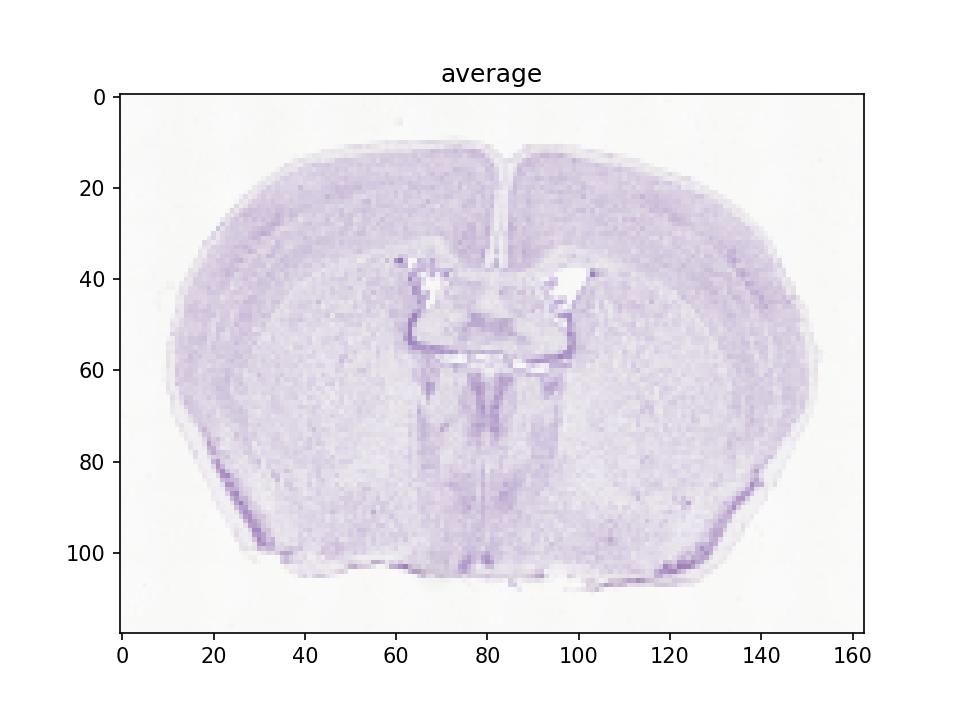

<IPython.core.display.Javascript object>


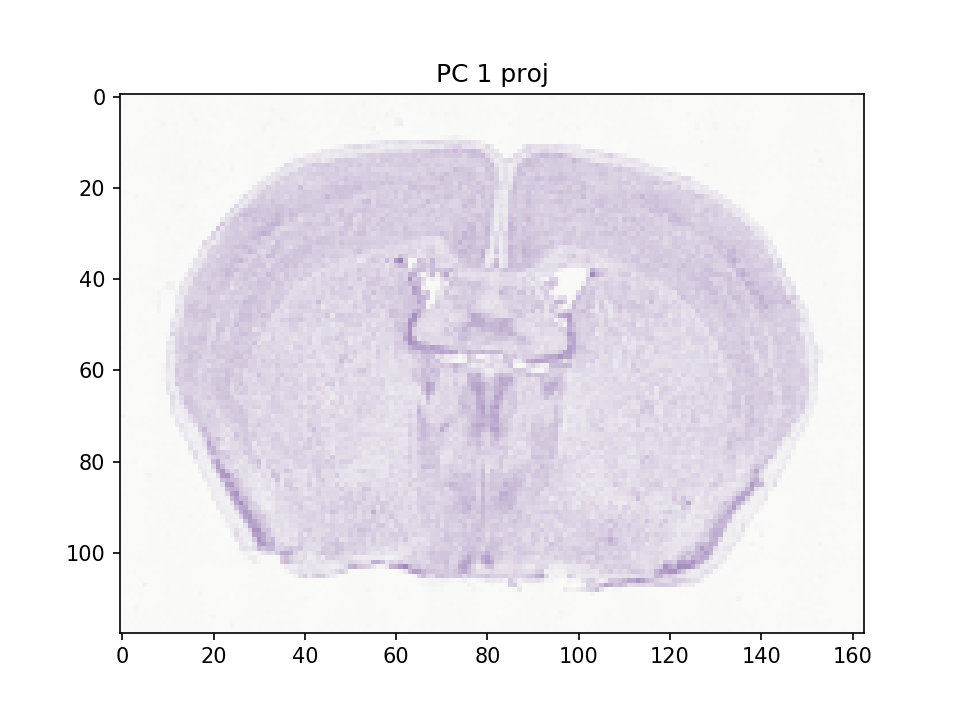

<IPython.core.display.Javascript object>


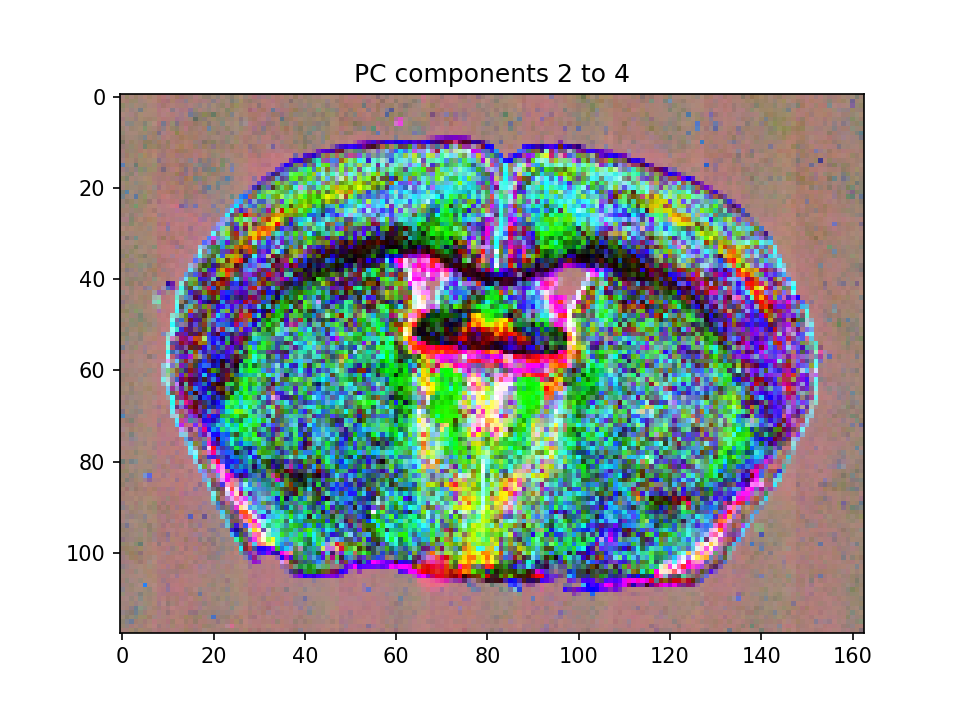

<IPython.core.display.Javascript object>


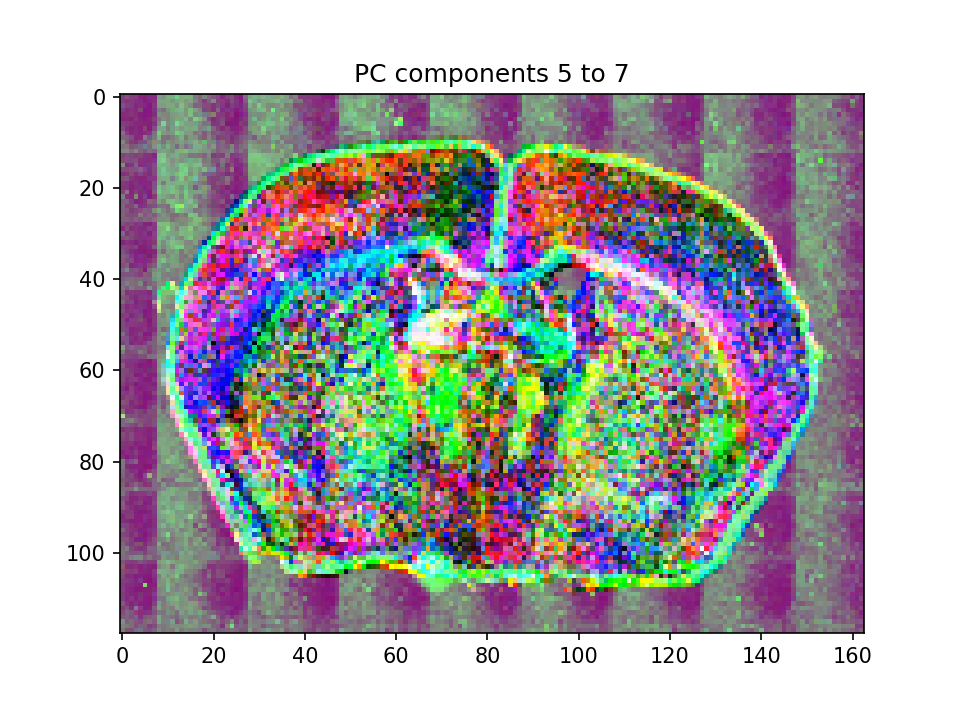

In [12]:
fav,f1,fs1,fs2 = draw(I)

# Rotation invariance
We combine paths that differ only by a rotation.

We combine them using two Fourier components, averaging and interference sums.

In [13]:
# now we want to combine them by averaging, taking interference sums, over rotations
def rot(label):
    rotated_label = []
    for l in label:
        if l == '1':
            rotated_label.append('2')
        elif l == '2':
            rotated_label.append('3')
        elif l == '3':
            rotated_label.append('4')
        elif l == '4':
            rotated_label.append('1')
        else:
            rotated_label.append(l)
    return ''.join(rotated_label)


In [14]:
# now we are looking for sets of 4
# a better strategy would be to link them and do a fft
# maybe an ifft since it has the 1/N
J = []
label_J = []
done = np.zeros(I.shape[-1])
for i in range(I.shape[-1]):
    if done[i]:
        continue
        
    label = labels[i]    
    rotated_label_1 = rot(label)
    rotated_label_2 = rot(rotated_label_1)
    rotated_label_3 = rot(rotated_label_2)
    
    print(label,rotated_label_1,rotated_label_2,rotated_label_3)    
    ind_1 = labels.index(rotated_label_1)
    ind_2 = labels.index(rotated_label_2)
    ind_3 = labels.index(rotated_label_3)
    print(ind_1)
    if ind_1 == i:
        # this is the case where everything is zeros
        J.append(I[...,i])
        done[i] = 1
    else:        
        J.append(I[...,i]*0.25+I[...,ind_1]*0.25+I[...,ind_2]*0.25+I[...,ind_3]*0.25)    
        done[i] = 1
        done[ind_1] = 1
        done[ind_2] = 1
        done[ind_3] = 1        
    label_J.append(label)
J = np.stack(J,-1)

R000000 R000000 R000000 R000000
0
G000000 G000000 G000000 G000000
1
B000000 B000000 B000000 B000000
2
R010000 R020000 R030000 R040000
6
G010000 G020000 G030000 G040000
7
B010000 B020000 B030000 B040000
8
R001000 R002000 R003000 R004000
30
G001000 G002000 G003000 G004000
31
B001000 B002000 B003000 B004000
32
R011000 R022000 R033000 R044000
36
G011000 G022000 G033000 G044000
37
B011000 B022000 B033000 B044000
38
R021000 R032000 R043000 R014000
39
G021000 G032000 G043000 G014000
40
B021000 B032000 B043000 B014000
41
R031000 R042000 R013000 R024000
42
G031000 G042000 G013000 G024000
43
B031000 B042000 B013000 B024000
44
R041000 R012000 R023000 R034000
33
G041000 G012000 G023000 G034000
34
B041000 B012000 B023000 B034000
35
R000100 R000200 R000300 R000400
102
G000100 G000200 G000300 G000400
103
B000100 B000200 B000300 B000400
104
R010100 R020200 R030300 R040400
108
G010100 G020200 G030300 G040400
109
B010100 B020200 B030300 B040400
110
R020100 R030200 R040300 R010400
111
G020100 G030200 G04

<IPython.core.display.Javascript object>


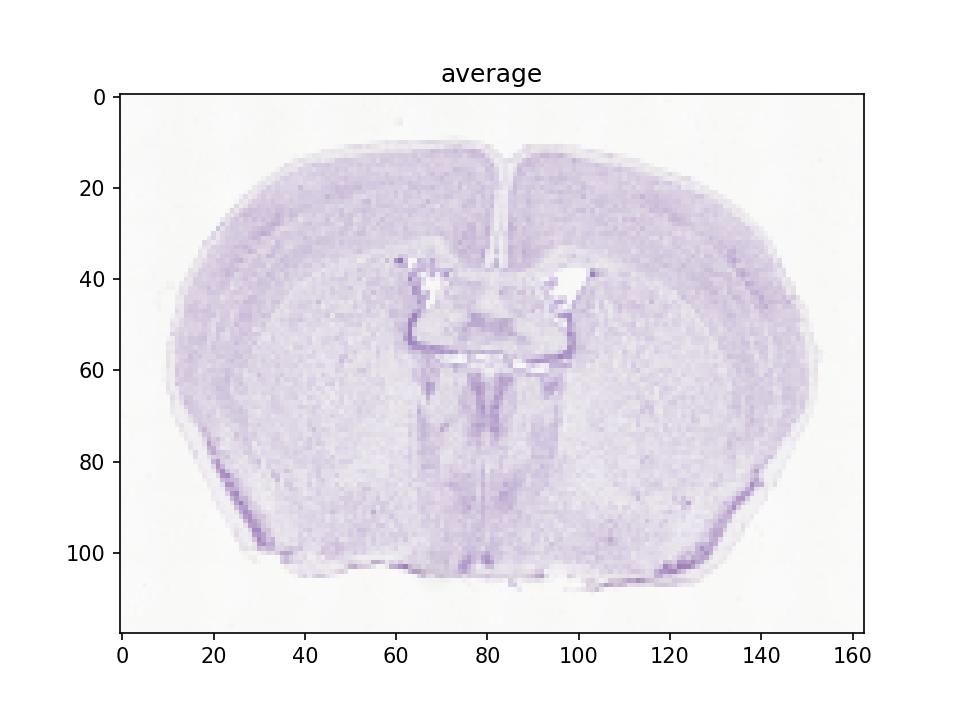

<IPython.core.display.Javascript object>


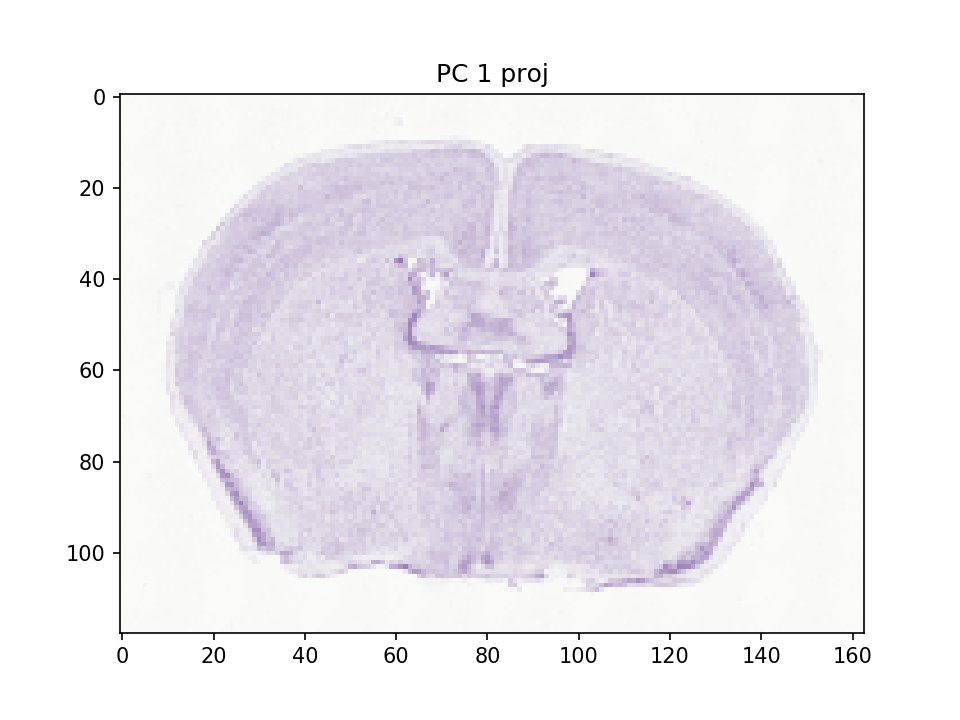

<IPython.core.display.Javascript object>


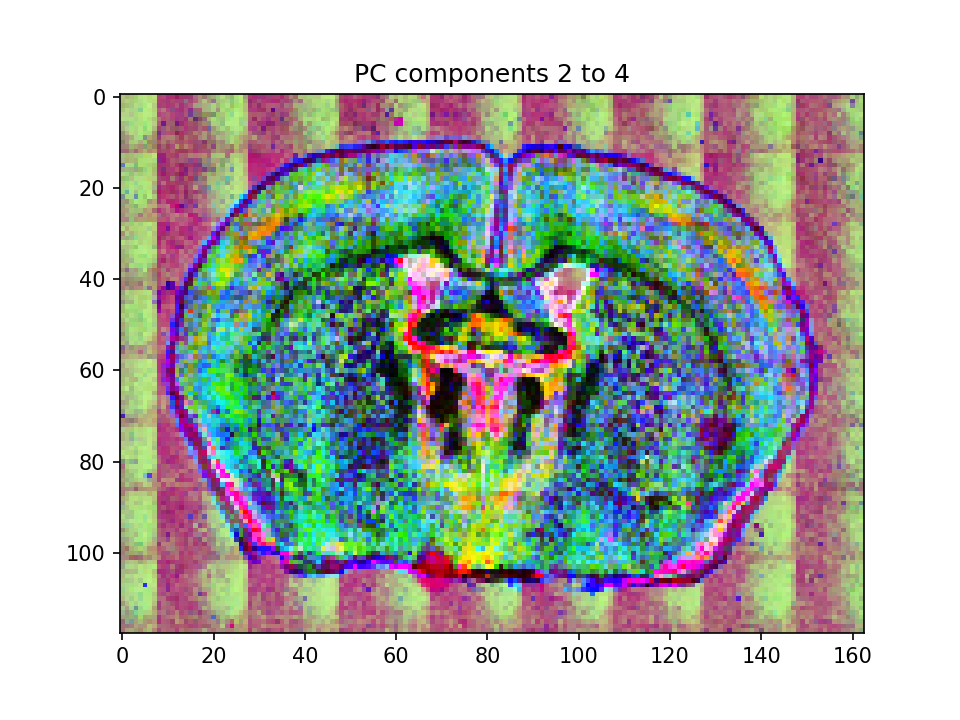

<IPython.core.display.Javascript object>


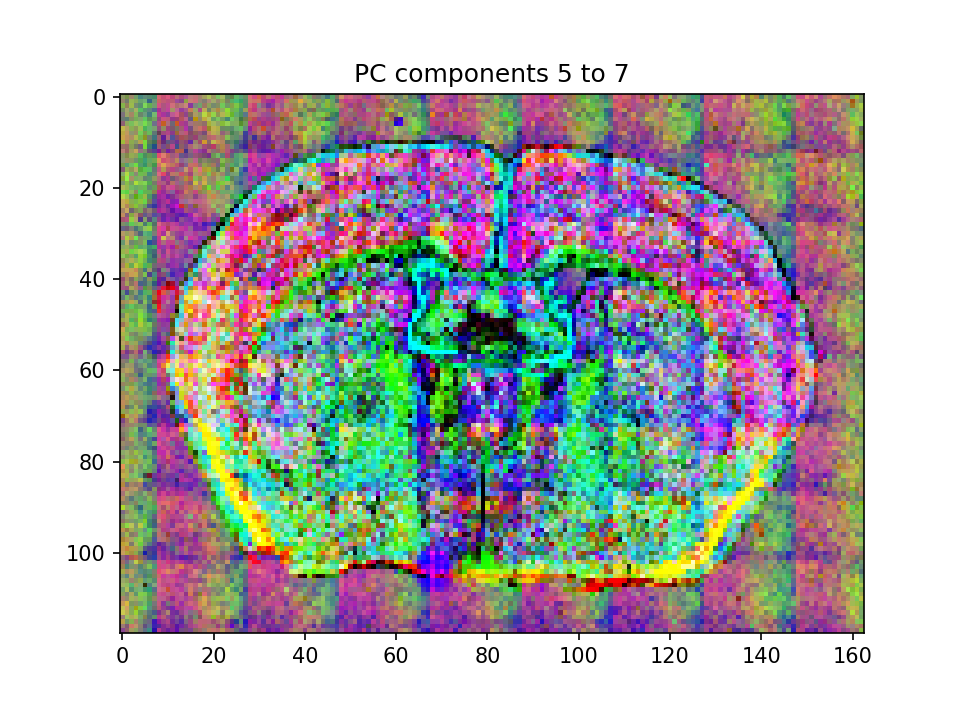

In [15]:
fav,f1,fs1,fs2 = draw(J)

In [16]:
# now we are elooking for sets of 4
# a better strategy would be to link them and do a fft
# maybe an ifft since it has the 1/N
K = []
label_K = []
done = np.zeros(I.shape[-1])
for i in range(I.shape[-1]):
    if done[i]:
        continue
        
    label = labels[i]    
    rotated_label_1 = rot(label)
    rotated_label_2 = rot(rotated_label_1)
    rotated_label_3 = rot(rotated_label_2)
    
    #print(label,rotated_label_1,rotated_label_2,rotated_label_3)    
    ind_1 = labels.index(rotated_label_1)
    ind_2 = labels.index(rotated_label_2)
    ind_3 = labels.index(rotated_label_3)
    #print(ind_1)
    if ind_1 == i:
        # this is the case where everything is zeros
        K.append(I[...,i])
        done[i] = 1
        label_K.append(label + '_')
    else:        
        K.append(I[...,i]*0.25+I[...,ind_1]*0.25+I[...,ind_2]*0.25+I[...,ind_3]*0.25)    
        K.append(np.abs(I[...,i]*0.25+I[...,ind_1]*0.25*np.exp(0.25*np.pi*1j)+I[...,ind_2]*0.25*np.exp(0.5*np.pi*1j)+I[...,ind_3]*0.25*np.exp(0.75*np.pi*1j))    )
        done[i] = 1
        done[ind_1] = 1
        done[ind_2] = 1
        done[ind_3] = 1        
        label_K.append(label + '+')
        label_K.append(label + '-')
K = np.stack(K,-1)

<IPython.core.display.Javascript object>


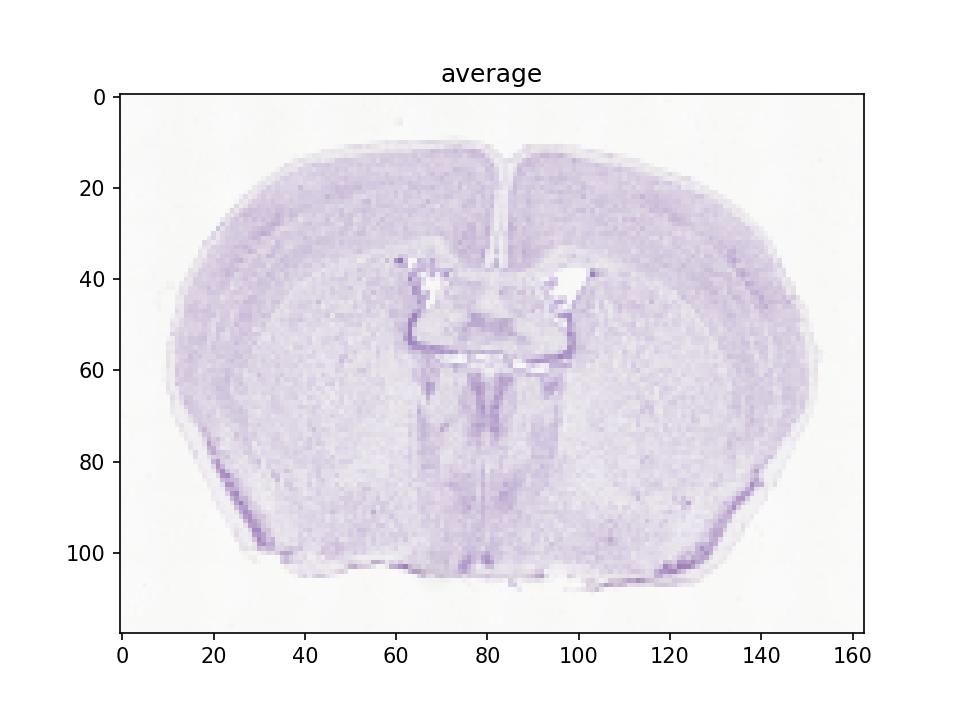

<IPython.core.display.Javascript object>


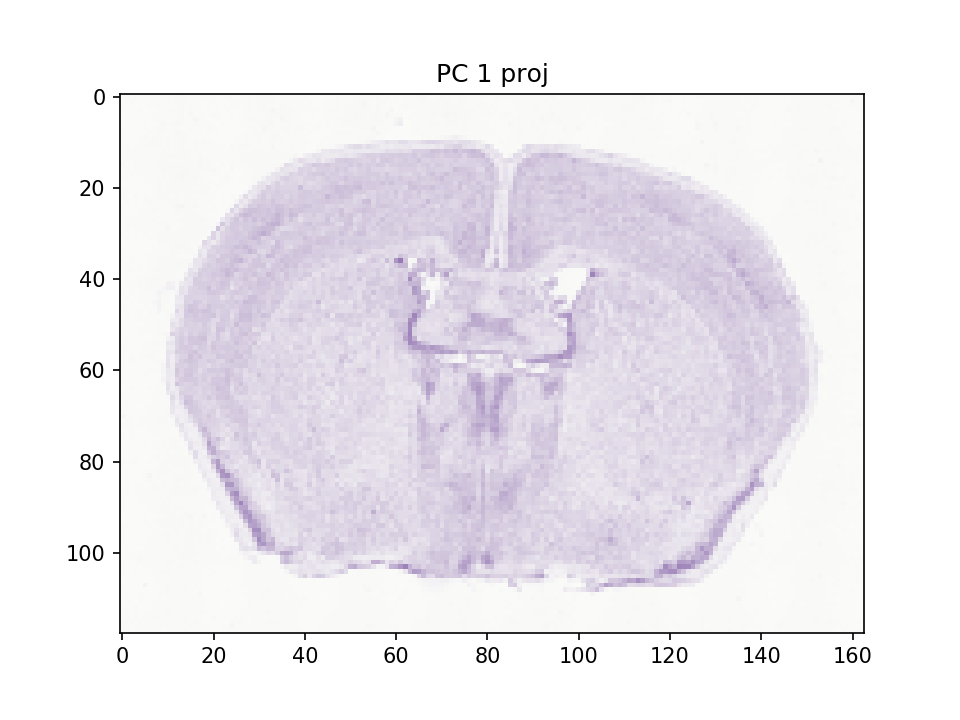

<IPython.core.display.Javascript object>


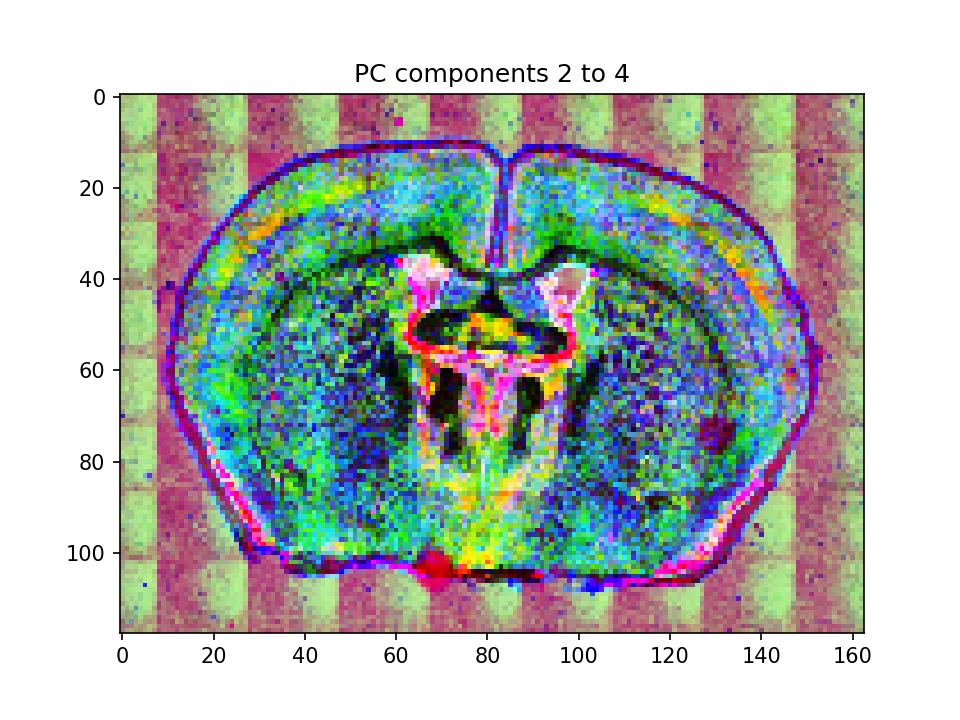

<IPython.core.display.Javascript object>


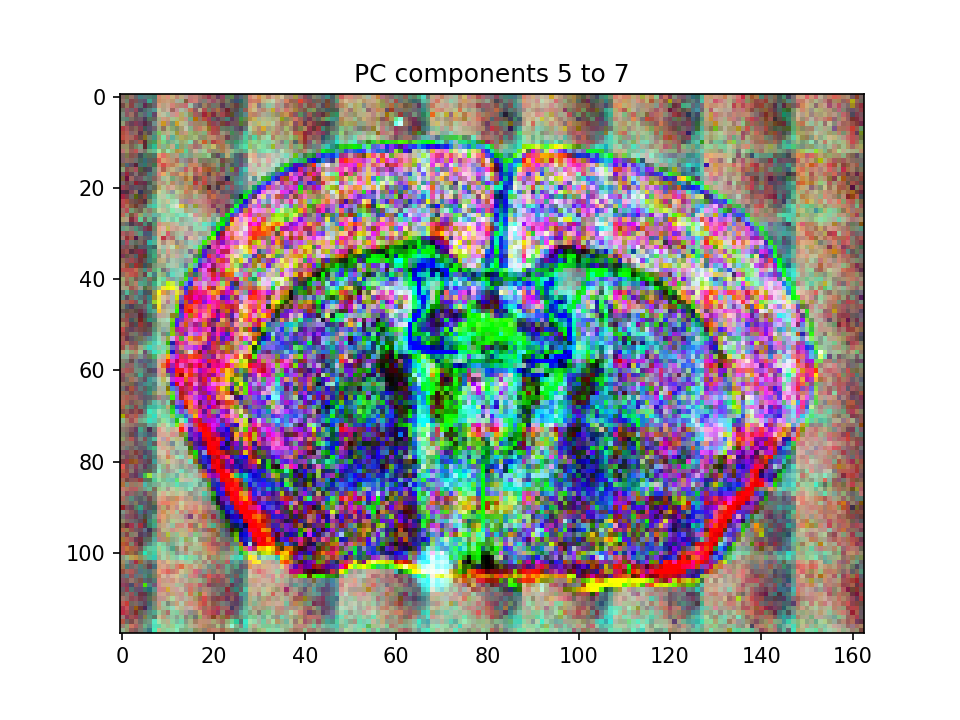

In [17]:
fav,f1,fs1,fs2 = draw(K)

# Reflection invariance
Now we combine paths that differ by only a reflection.

In [18]:
# we want to take a label and get a turn
# this will be a different sequence
# now there's either
# (l)eft
# (r)ight
# (n)inety
# or (p)arallel
def label_to_turn(label):
    label_turn = []
    first_direction = ''
    last_direction = ''
    for l in label:
        if l not in '1234':
            label_turn.append(l)
        else:
            if first_direction:
                # here we compare to last direction
                if last_direction == '1':
                    if l == '1':
                        label_turn.append('p')
                    elif l == '2':
                        label_turn.append('l')
                    elif l == '3':
                        label_turn.append('n')
                    elif l == '4':
                        label_turn.append('r')
                elif last_direction == '2':
                    if l == '1':
                        label_turn.append('r')
                    elif l == '2':
                        label_turn.append('p')
                    elif l == '3':
                        label_turn.append('l')
                    elif l == '4':
                        label_turn.append('n')
                elif last_direction == '3':
                    if l == '1':
                        label_turn.append('n')
                    elif l == '2':
                        label_turn.append('r')
                    elif l == '3':
                        label_turn.append('p')
                    elif l == '4':
                        label_turn.append('l')
                elif last_direction == '4':
                    if l == '1':
                        label_turn.append('l')
                    elif l == '2':
                        label_turn.append('n')
                    elif l == '3':
                        label_turn.append('r')
                    elif l == '4':
                        label_turn.append('p')

                last_direction = l

            else:
                first_direction = l
                last_direction = l
                label_turn.append(l)
    return ''.join(label_turn)
                


In [19]:
# now we need to go the other way
def turn_to_label(turn):

    last_direction = ''
    labels_ = []
    for t in turn:
        if t not in 'lrpn':
            labels_.append(t)
            if t in '1234':
                last_direction = t
        else:
            # compare to last direction
            if last_direction == '1':
                if t == 'p':
                    labels_.append('1')
                elif t == 'l':
                    labels_.append('2')
                elif t == 'n':
                    labels_.append('3')
                elif t == 'r':
                    labels_.append('4')
            elif last_direction == '2':
                if t == 'p':
                    labels_.append('2')
                elif t == 'l':
                    labels_.append('3')
                elif t == 'n':
                    labels_.append('4')
                elif t == 'r':
                    labels_.append('1')
            elif last_direction == '3':
                if t == 'p':
                    labels_.append('3')
                elif t == 'l':
                    labels_.append('4')
                elif t == 'n':
                    labels_.append('1')
                elif t == 'r':
                    labels_.append('2')
            elif last_direction == '4':
                if t == 'p':
                    labels_.append('4')
                elif t == 'l':
                    labels_.append('1')
                elif t == 'n':
                    labels_.append('2')
                elif t == 'r':
                    labels_.append('3')

            last_direction = labels_[-1]
    return ''.join(labels_)

            
            
            
            


In [20]:
def reflect(label):
    turn = label_to_turn(label)
    reflected_turn = []
    for t in turn:
        if t not in 'rl':
            reflected_turn.append(t)
        elif t == 'r':
            reflected_turn.append('l')
        elif t == 'l':
            reflected_turn.append('r')
    reflected_label = turn_to_label(reflected_turn)
    return ''.join(reflected_label)
            
            
    

In [21]:
# now we are looking for reflections
# it seems that a lot of the reflections are gone
L = []
label_L = []
done = np.zeros(J.shape[-1])
for i in range(J.shape[-1]):
    if done[i]:        
        continue
        
    label = label_J[i]    
    reflected_label = reflect(label)
        

    try:
        ind = label_J.index(reflected_label)
    except:
        try:
            ind = label_J.index(rot(reflected_label))
        except:
            try:
                ind = label_J.index(rot(rot(reflected_label)))
            except:
                try:
                    ind = label_J.index(rot(rot(rot(reflected_label))))
                except:
                    print('coudnt find one')
                    ind = i # don't do anything    
    if ind == i:
        # this is the case where everything is zeros
        L.append(J[...,i])
        done[i] = 1
        label_L.append(label)
    else:                
        L.append(J[...,i]*0.5+J[...,ind]*0.5)    
        
        done[i] = 1
        done[ind] = 1        
        label_L.append(label)
        
L = np.stack(L,-1)

<IPython.core.display.Javascript object>


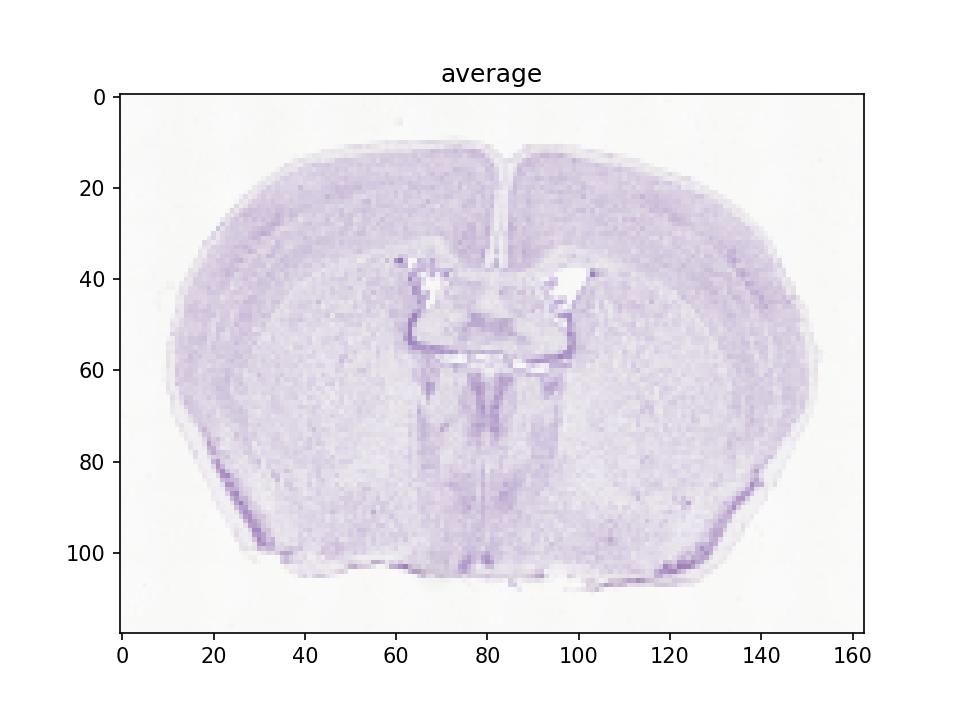

<IPython.core.display.Javascript object>


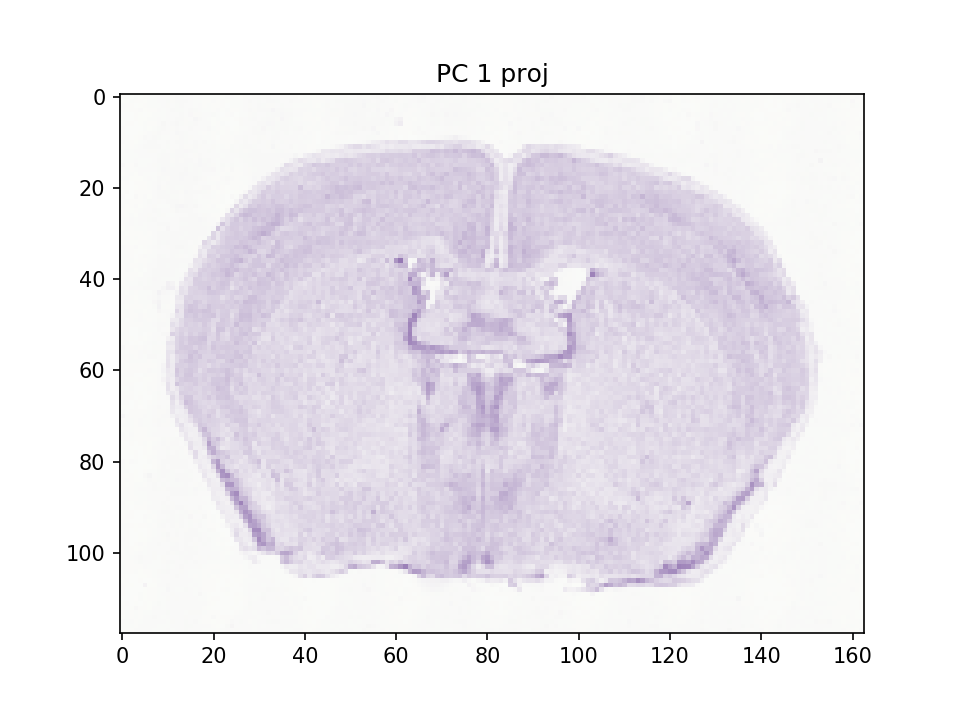

<IPython.core.display.Javascript object>


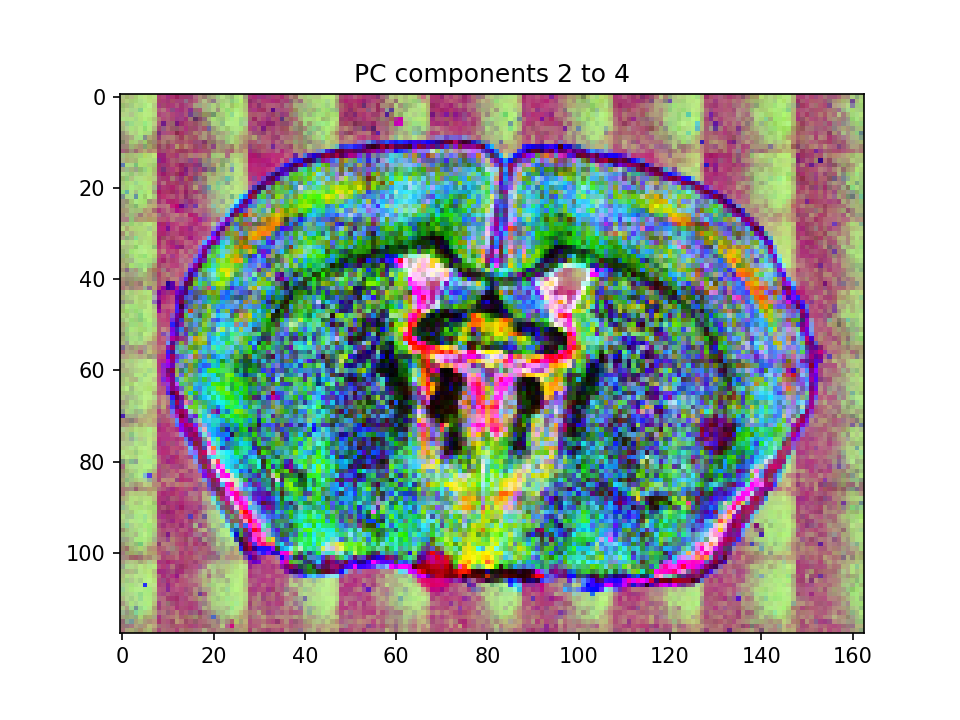

<IPython.core.display.Javascript object>


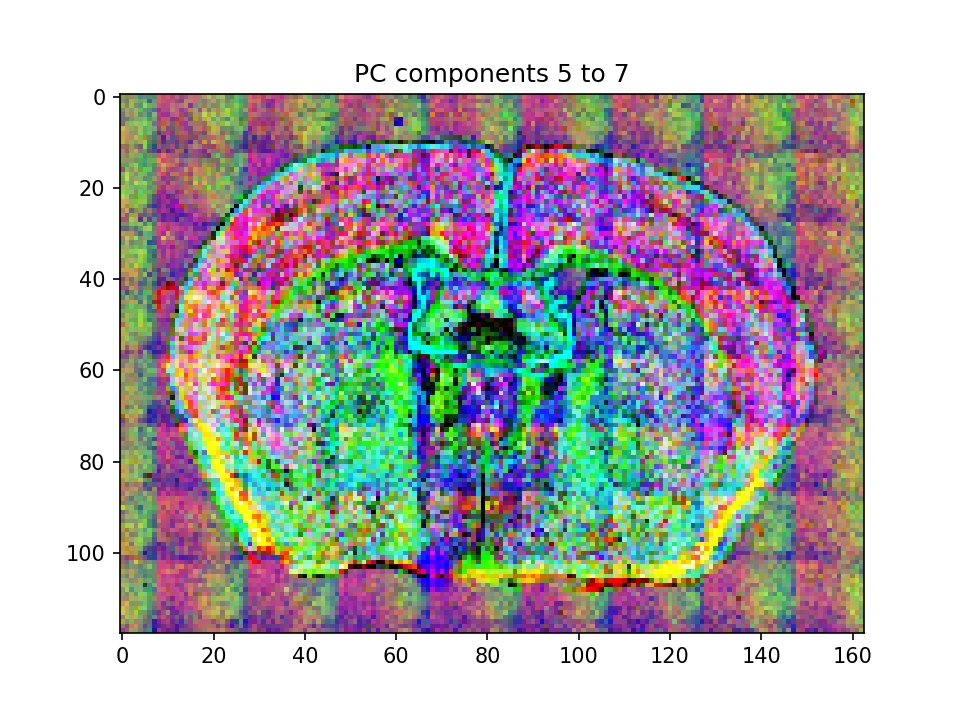

In [22]:
fav,f1,fs1,fs2 = draw(L)

In [23]:
# now we are looking for reflections
# it seems that a lot of the reflections are gone
M = []
label_M = []
done = np.zeros(K.shape[-1])
for i in range(K.shape[-1]):
    if done[i]:        
        continue
        
    label = label_K[i]    
    reflected_label = reflect(label)
        

    try:
        ind = label_K.index(reflected_label)
    except:
        try:
            ind = label_K.index(rot(reflected_label))
        except:
            try:
                ind = label_K.index(rot(rot(reflected_label)))
            except:
                try:
                    ind = label_K.index(rot(rot(rot(reflected_label))))
                except:
                    print('coudnt find one')
                    ind = i # don't do anything    
    if ind == i:
        # this is the case where everything is zeros
        M.append(K[...,i])
        done[i] = 1
        label_M.append(label)
    else:                
        M.append(K[...,i]*0.5+K[...,ind]*0.5)
        M.append(np.abs(K[...,i]*0.5-K[...,ind]*0.5))
        
        done[i] = 1
        done[ind] = 1        
        label_M.append(label + '=')
        label_M.append(label + '_')
        
M = np.stack(M,-1)

<IPython.core.display.Javascript object>


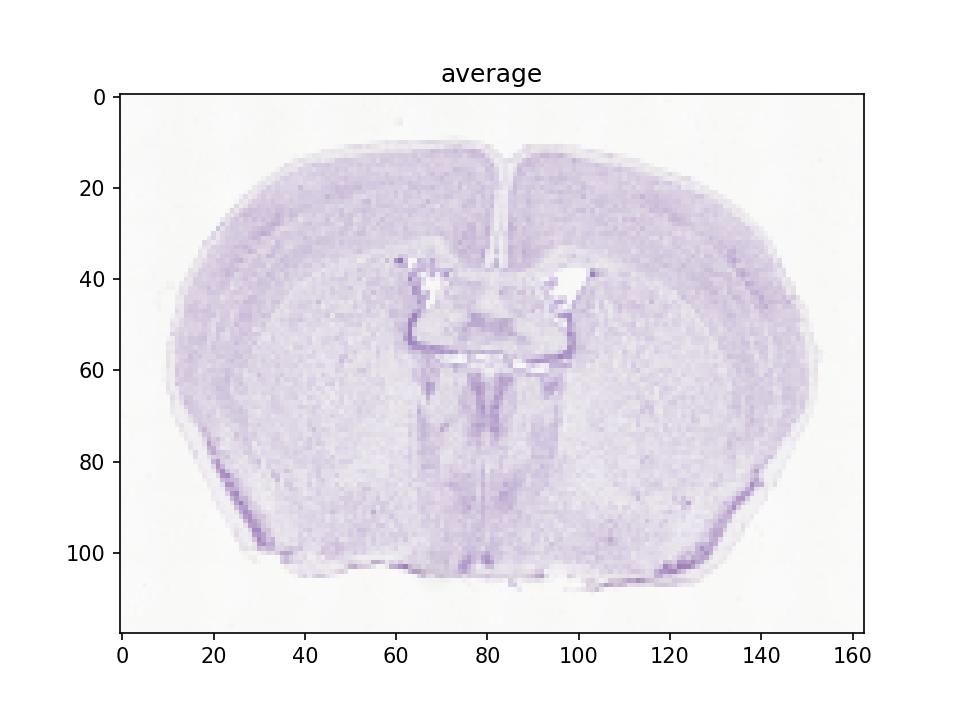

<IPython.core.display.Javascript object>


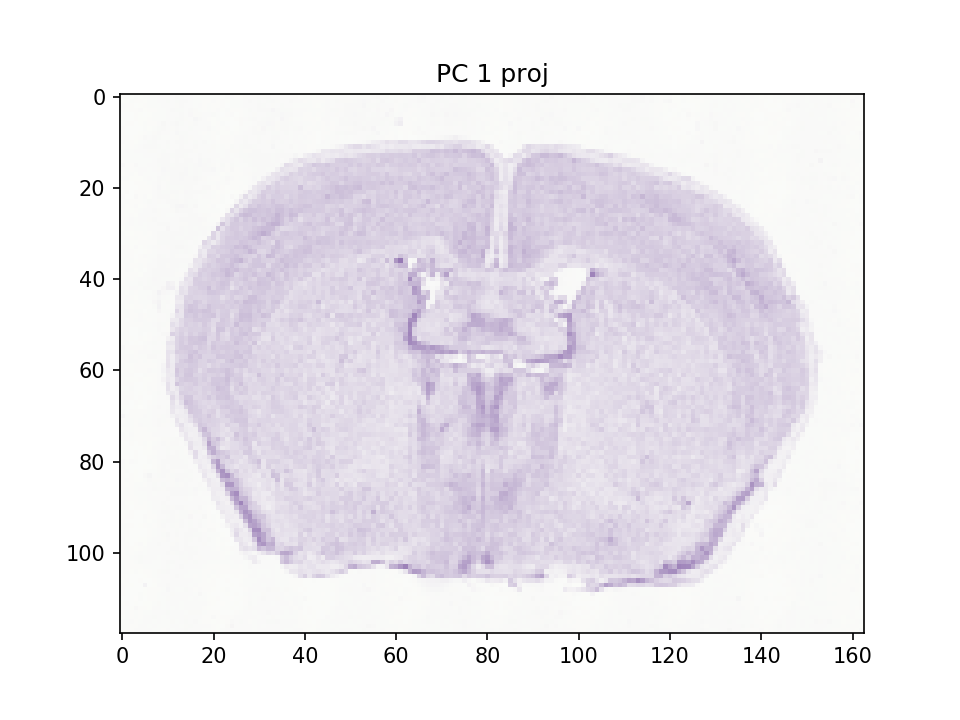

<IPython.core.display.Javascript object>


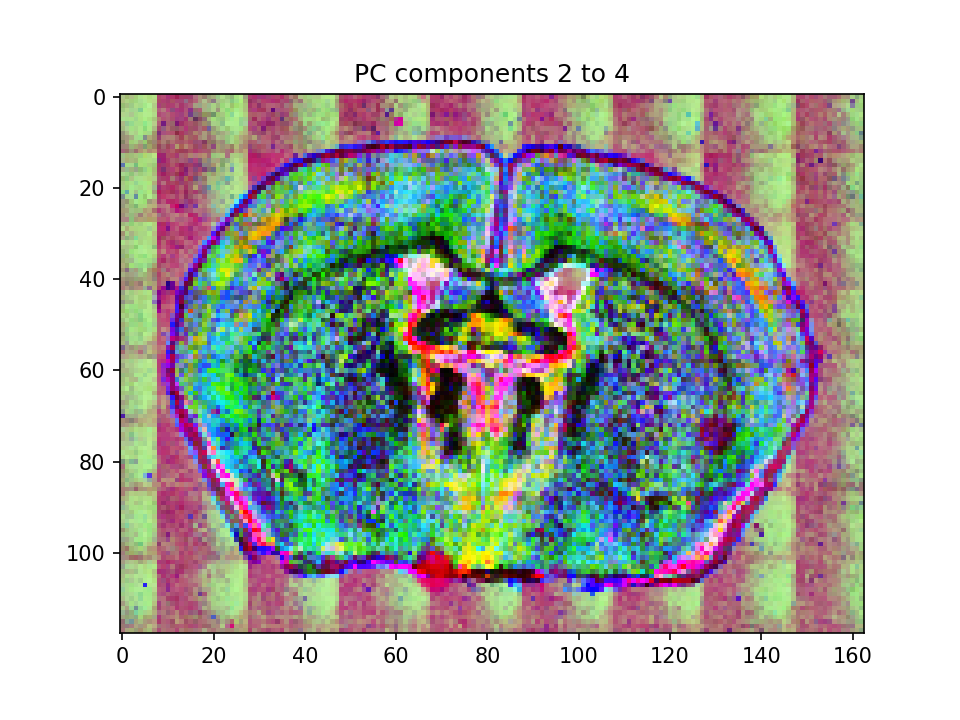

<IPython.core.display.Javascript object>


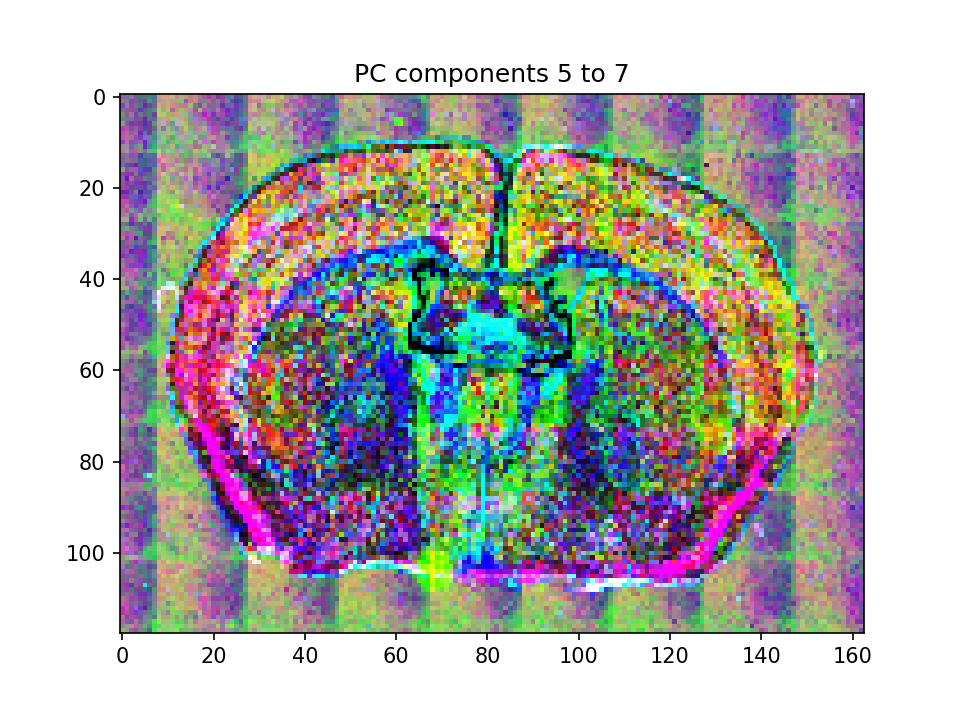

In [24]:
fav,f1,fs1,fs2 = draw(M)

In [25]:
# let's save the interesting outputs
outdir = 'figures'
if not os.path.exists(outdir):
    os.mkdir(outdir)
dirname,filename = os.path.split(fname) 
filebase,filext = os.path.splitext(filename)


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


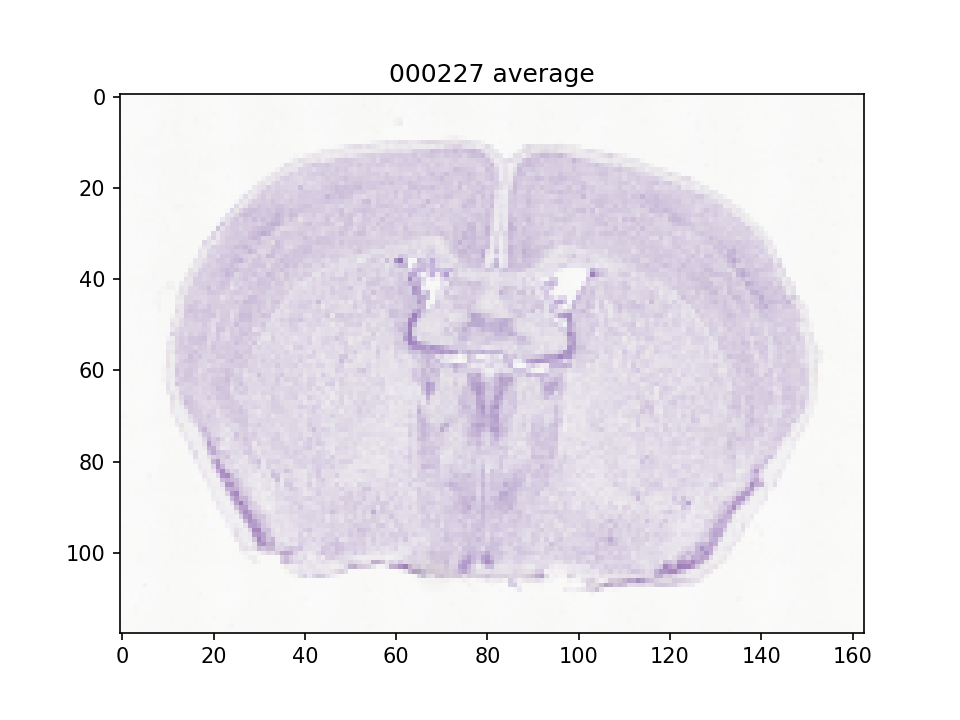

4294967296 4294967296


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


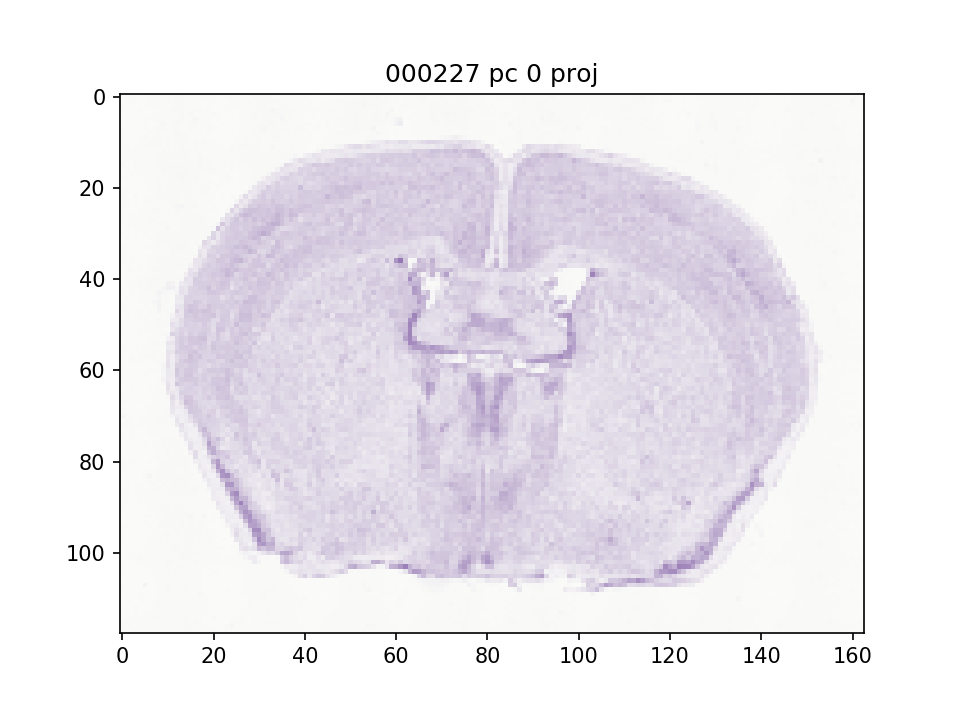

4294967296 4294967296


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


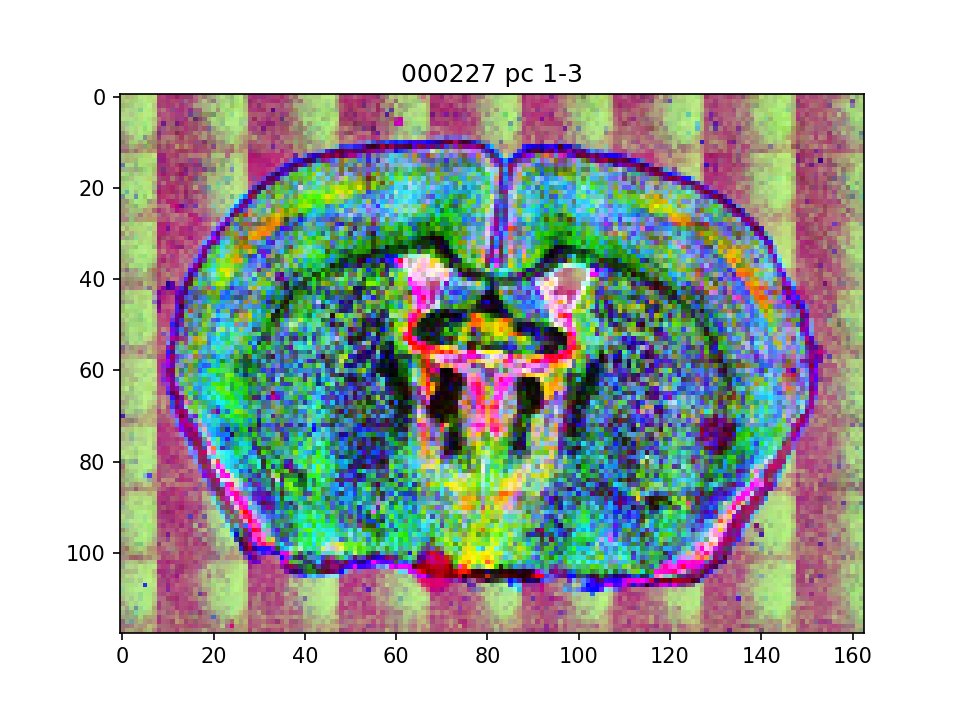

4294967296 4294967296


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


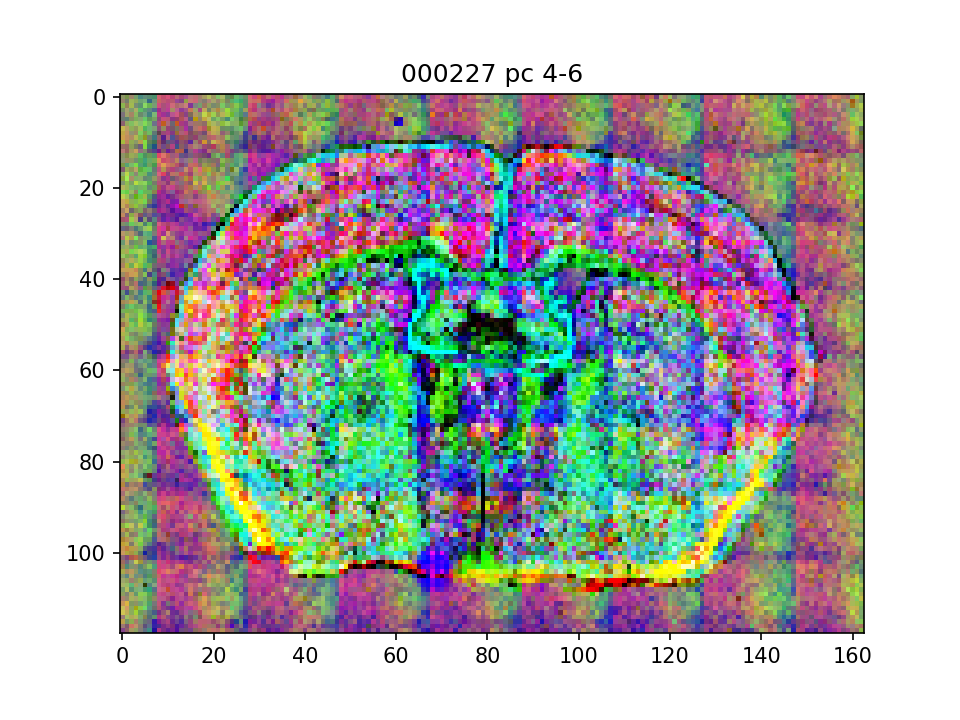

4294967296 4294967296


In [26]:
# save the full averaged data, this is L
np.savez(os.path.join(outdir,filebase+'.npz'),I=L,labels=label_L)
f,ax = plt.subplots()
ax.imshow(L[...,:3])
ax.set_title(filebase.split('_')[1]+' average')
f.savefig(os.path.join(outdir,filebase+'_average.jpg'))

w = None
Lp,sL,vL = pca(L,w=w,output_v=True)
Ls = pca_scale(Lp[...,:7],sL[:7])
# let's project L onto the first PC
if w is not None:
    muL = np.sum(L*w[...,None],axis=(0,1),keepdims=True)/np.sum(w)
else:
    muL = np.mean(L,axis=(0,1),keepdims=True)
c = np.sum(vL[:,0]*(L - muL),-1)

    
# let's project L onto the first PC
if w is not None:
    muL = np.sum(L*w[...,None],axis=(0,1),keepdims=True)/np.sum(w)
else:
    muL = np.mean(L,axis=(0,1),keepdims=True)

c = np.sum(vL[:,0]*(L - muL),-1)
f,ax = plt.subplots()
ax.imshow(c[...,None]*vL[:3,0] + muL[...,:3])
ax.set_title(filebase.split('_')[1]+' pc 0 proj')
f.savefig(os.path.join(outdir,filebase+'_pc_0.jpg'))

f,ax = plt.subplots()
ax.imshow(Ls[...,1:4])
ax.set_title(filebase.split('_')[1]+' pc 1-3')
f.savefig(os.path.join(outdir,filebase+'_pc_1_3.jpg'))

f,ax = plt.subplots()
ax.imshow(Ls[...,4:7])
ax.set_title(filebase.split('_')[1]+' pc 4-6')
f.savefig(os.path.join(outdir,filebase+'_pc_4_6.jpg'))

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


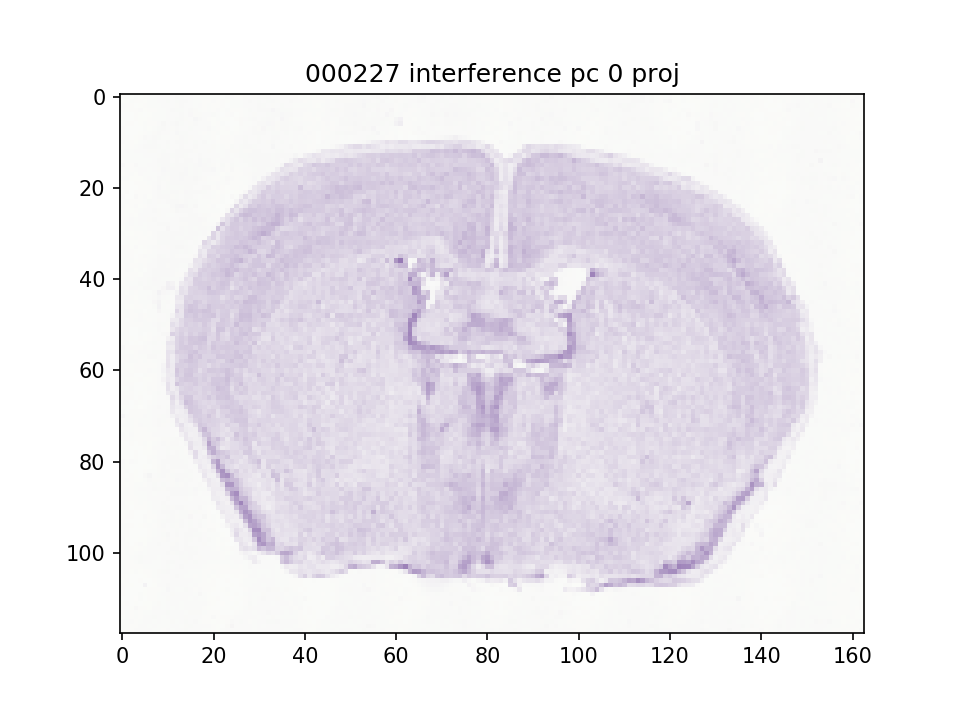

4294967296 4294967296


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


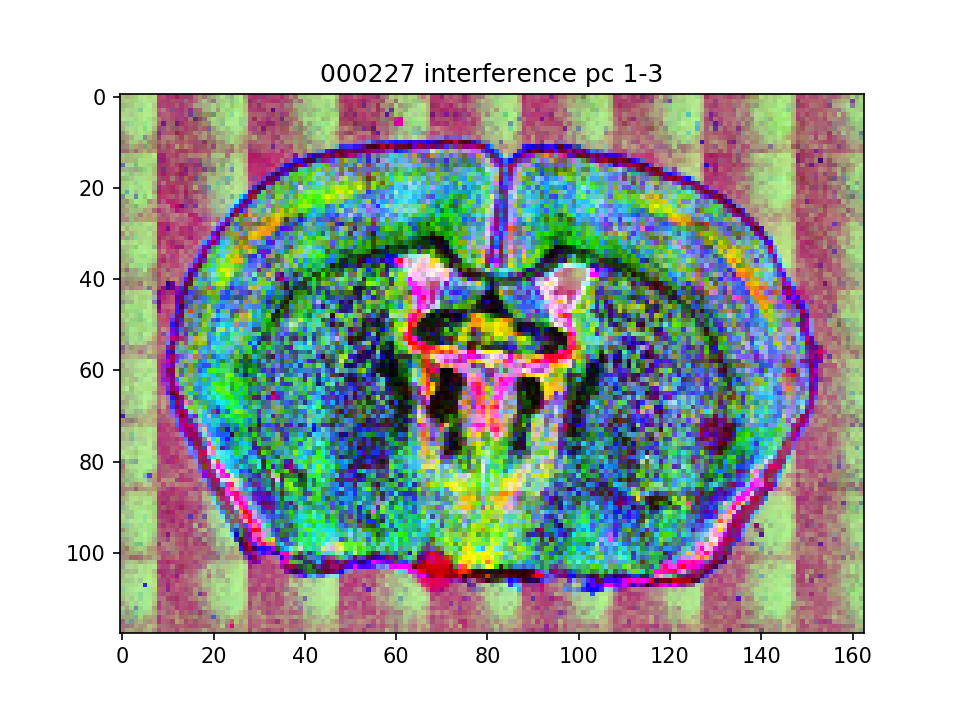

4294967296 4294967296


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


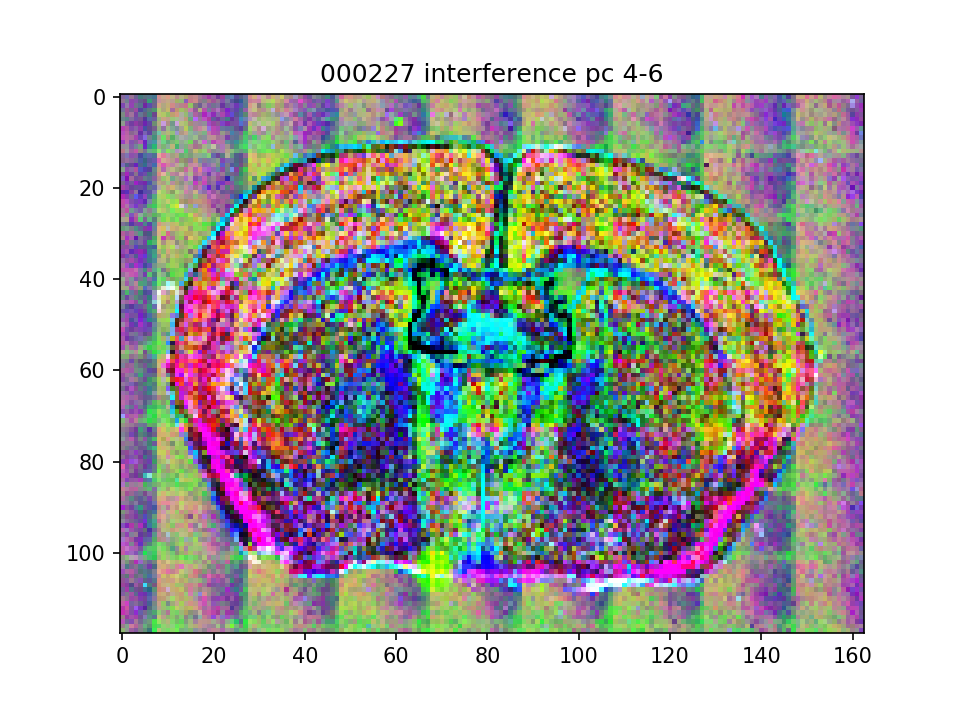

4294967296 4294967296


In [27]:
# rename some variables to avoid repeating code
Lsave = np.array(L)
L = np.array(M)
Lp,sL,vL = pca(L,w=w,output_v=True)
Ls = pca_scale(Lp[...,:7],sL[:7])
# let's project L onto the first PC
if w is not None:
    muL = np.sum(L*w[...,None],axis=(0,1),keepdims=True)/np.sum(w)
else:
    muL = np.mean(L,axis=(0,1),keepdims=True)
c = np.sum(vL[:,0]*(L - muL),-1)

    
# let's project L onto the first PC
if w is not None:
    muL = np.sum(L*w[...,None],axis=(0,1),keepdims=True)/np.sum(w)
else:
    muL = np.mean(L,axis=(0,1),keepdims=True)

c = np.sum(vL[:,0]*(L - muL),-1)
f,ax = plt.subplots()
ax.imshow(c[...,None]*vL[:3,0] + muL[...,:3])
ax.set_title(filebase.split('_')[1]+' interference pc 0 proj')
f.savefig(os.path.join(outdir,filebase+'_interference_pc_0.jpg'))

f,ax = plt.subplots()
ax.imshow(Ls[...,1:4])
ax.set_title(filebase.split('_')[1]+' interference pc 1-3')
f.savefig(os.path.join(outdir,filebase+'_interference_pc_1_3.jpg'))

f,ax = plt.subplots()
ax.imshow(Ls[...,4:7])
ax.set_title(filebase.split('_')[1]+' interference pc 4-6')
f.savefig(os.path.join(outdir,filebase+'_interference_pc_4_6.jpg'))


M = np.array(L)

In [28]:
# I'd really like a pca viewer
# or an lda viewer
# with pca move the mouse around
# with lda click and drag
